In [1]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [2]:
fname = "2020_11_12.hdf"
dset_name = "1605230079 scan polarization switching frequency"

devices = ()

In [3]:
pmt_channel = 1
shutter_channel = 2

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [4]:
microwave_frequency_data = {}
attr_name = 'SDG1032X SetChannel1Frequency'
for idx in range(1,len(pxie)+1):
    microwave_frequency_data[float(pxie_attrs[idx][attr_name])] = {'open': [], 'closed': []}

In [5]:
for idx in range(1,len(pxie)+1):
    μpower = float(pxie_attrs[idx][attr_name])
    
    traces = pxie[idx]
    pmt = -traces[:,pmt_channel].astype(float)
    pmt -= np.mean(pmt[150:250])
    shutter_state = traces[:,shutter_channel].mean() > 2e4
    if shutter_state:
        microwave_frequency_data[μpower]['open'].append(pmt)
    else:
        microwave_frequency_data[μpower]['closed'].append(pmt)

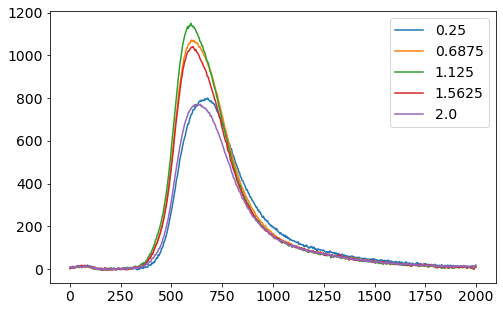

In [6]:
fig, ax = plt.subplots(figsize = (8,5))
for p in list(microwave_frequency_data.keys()):
    ax.plot(np.mean(microwave_frequency_data[p]['open'], axis = 0), label = p)
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

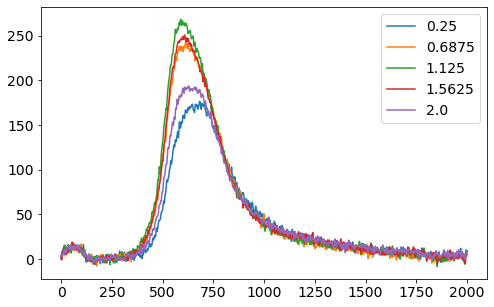

In [7]:
fig, ax = plt.subplots(figsize = (8,5))
for p in list(microwave_frequency_data.keys()):
    ax.plot(np.mean(microwave_frequency_data[p]['closed'], axis = 0), label = p)
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [13]:
for f in list(microwave_frequency_data.keys()):
    io = np.trapz(np.mean(microwave_frequency_data[f]['open'], axis = 0)[200:])
    ic = np.trapz(np.mean(microwave_frequency_data[f]['closed'], axis = 0)[200:])
    print(f'{f:.2f} Hz -> {io/ic:.3f} ratio')

0.25 Hz -> 4.488 ratio
0.69 Hz -> 4.362 ratio
1.12 Hz -> 4.170 ratio
1.56 Hz -> 4.048 ratio
2.00 Hz -> 3.822 ratio


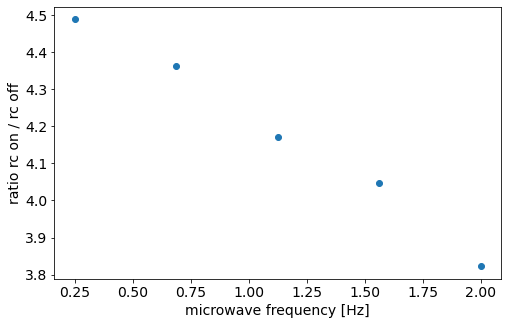

In [10]:
fig, ax = plt.subplots(figsize = (8,5))
for f in list(microwave_frequency_data.keys()):
    io = np.trapz(np.mean(microwave_frequency_data[f]['open'], axis = 0)[200:])
    ic = np.trapz(np.mean(microwave_frequency_data[f]['closed'], axis = 0)[200:])
    ax.plot(f, io/ic, '.', ms = 12, color = 'C0')
    

ax.set_xlabel('microwave frequency [Hz]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

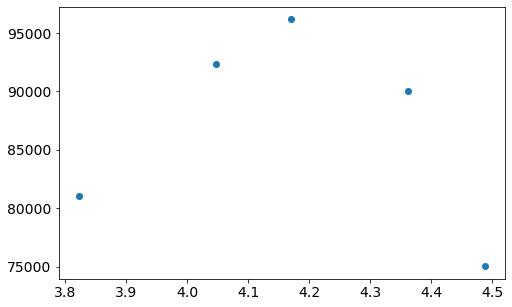

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
for f in list(microwave_frequency_data.keys()):
    io = np.trapz(np.mean(microwave_frequency_data[f]['open'], axis = 0)[200:])
    ic = np.trapz(np.mean(microwave_frequency_data[f]['closed'], axis = 0)[200:])
    ratio = io/ic
    
    integral_c = np.trapz(np.mean(microwave_frequency_data[f]['closed'], axis = 0)[200:])
    ax.plot(ratio, integral_c, '.', ms = 12, color = 'C0')
    
set_fontsize(ax, 14)

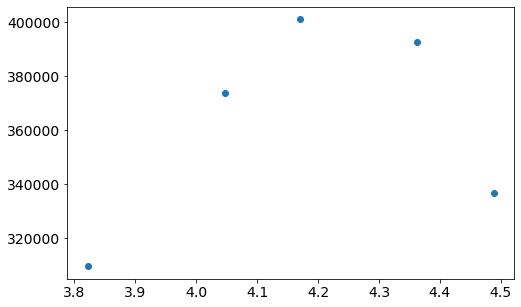

In [12]:
fig, ax = plt.subplots(figsize = (8,5))
for f in list(microwave_frequency_data.keys()):
    io = np.trapz(np.mean(microwave_frequency_data[f]['open'], axis = 0)[200:])
    ic = np.trapz(np.mean(microwave_frequency_data[f]['closed'], axis = 0)[200:])
    ratio = io/ic
    
    integral_o = np.trapz(np.mean(microwave_frequency_data[f]['open'], axis = 0)[200:])
    ax.plot(ratio, integral_o, '.', ms = 12, color = 'C0')
    
set_fontsize(ax, 14)

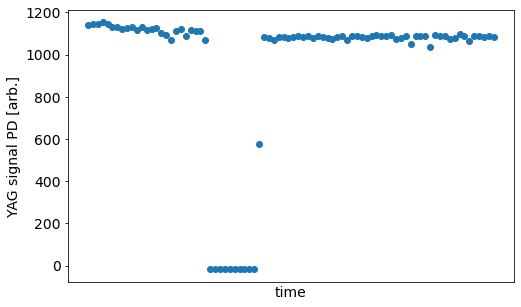

In [16]:
pd_data = []
for idx in range(1,len(pxie)+1):
    pd_data.append(pxie[idx][:,0])
pd_data = np.asarray(pd_data)

reshaped_data = pd_data.reshape(-1,250,2000).mean(axis = 1)
peaks = np.max(reshaped_data, axis = 1)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(peaks, '.', ms = 12)

ax.set_xticks([])

ax.set_xlabel('time')
ax.set_ylabel('YAG signal PD [arb.]')

set_fontsize(ax, 14)

Turned of the PD for a bit to check if some anomolous signal (from 0 to ~ 100) was a result of the PD signal on CH0 leaking into CH1 a little bit